## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [18]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-05-16 15:39:42--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.120.210
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.120.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  86.1MB/s    in 4.0s    

2021-05-16 15:39:46 (80.8 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [19]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (dropout): Dropout(p=0.2)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [97]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [98]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [99]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [100]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [101]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [102]:
use_cuda=True
if use_cuda:
    net.cuda()

# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        
        if use_cuda:
            images, key_pts = images.cuda(), key_pts.cuda()
 
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [103]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [104]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

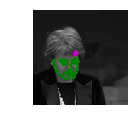

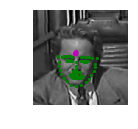

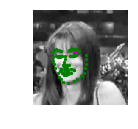

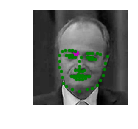

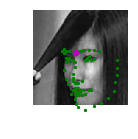

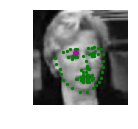

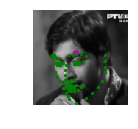

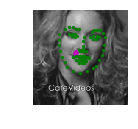

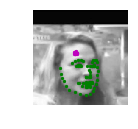

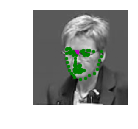

In [105]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output0(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
 

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    test_images=test_images.cpu()
    test_outputs=test_outputs.cpu()
    gt_pts=gt_pts.cpu()
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)


## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [112]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss().cuda() if torch.cuda.is_available() else nn.SmoothL1Loss()

optimizer = optim.Adam(params = net.parameters(), lr = 0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [113]:
def train_net0(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            #if batch_i % 10 == 9:    # print every 10 batches
            if batch_i % 3 == 2:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/3))
                running_loss = 0.0

    print('Finished Training')

    
use_cuda=True
if use_cuda:
    net.cuda()

import time
def train_net(n_epochs):

    start_time=time.time()
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            
            if use_cuda:
                images, key_pts = images.cuda(), key_pts.cuda()

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # forward pass to get outputs
            output_pts = net(images)

           
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print('Finished Training')



In [114]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.030093117989599703
Epoch: 1, Batch: 20, Avg. Loss: 0.028356996551156043
Epoch: 1, Batch: 30, Avg. Loss: 0.02679035868495703
Epoch: 1, Batch: 40, Avg. Loss: 0.027545185666531323
Epoch: 1, Batch: 50, Avg. Loss: 0.07670612260699272
Epoch: 1, Batch: 60, Avg. Loss: 0.030543377995491026
Epoch: 1, Batch: 70, Avg. Loss: 0.030810989812016486
Epoch: 1, Batch: 80, Avg. Loss: 0.029826029017567635
Epoch: 1, Batch: 90, Avg. Loss: 0.026143720373511314
Epoch: 1, Batch: 100, Avg. Loss: 0.03007800951600075
Epoch: 1, Batch: 110, Avg. Loss: 0.03050311841070652
Epoch: 1, Batch: 120, Avg. Loss: 0.03211130537092686
Epoch: 1, Batch: 130, Avg. Loss: 0.037607609294354916
Epoch: 1, Batch: 140, Avg. Loss: 0.025527141615748407
Epoch: 1, Batch: 150, Avg. Loss: 0.022083808295428754
Epoch: 1, Batch: 160, Avg. Loss: 0.030794946290552617
Epoch: 1, Batch: 170, Avg. Loss: 0.024546961579471827
Epoch: 1, Batch: 180, Avg. Loss: 0.025811546389013527
Epoch: 1, Batch: 190, Avg. Loss: 0.0326184

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.02474385956302285
Epoch: 2, Batch: 20, Avg. Loss: 0.02964874729514122
Epoch: 2, Batch: 30, Avg. Loss: 0.025483407266438007
Epoch: 2, Batch: 40, Avg. Loss: 0.023154986184090377
Epoch: 2, Batch: 50, Avg. Loss: 0.02209506193175912
Epoch: 2, Batch: 60, Avg. Loss: 0.0876147946342826
Epoch: 2, Batch: 70, Avg. Loss: 0.033487163856625556
Epoch: 2, Batch: 80, Avg. Loss: 0.02876313328742981
Epoch: 2, Batch: 90, Avg. Loss: 0.02850275095552206
Epoch: 2, Batch: 100, Avg. Loss: 0.031471144128590825
Epoch: 2, Batch: 110, Avg. Loss: 0.0645033536478877
Epoch: 2, Batch: 120, Avg. Loss: 0.027665568329393864
Epoch: 2, Batch: 130, Avg. Loss: 0.0261710362508893
Epoch: 2, Batch: 140, Avg. Loss: 0.02694487925618887
Epoch: 2, Batch: 150, Avg. Loss: 0.024250665213912725
Epoch: 2, Batch: 160, Avg. Loss: 0.030855119973421097
Epoch: 2, Batch: 170, Avg. Loss: 0.05945268394425511
Epoch: 2, Batch: 180, Avg. Loss: 0.027562954183667897
Epoch: 2, Batch: 190, Avg. Loss: 0.044304495304822

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.04831842593848705
Epoch: 3, Batch: 20, Avg. Loss: 0.033202932216227055
Epoch: 3, Batch: 30, Avg. Loss: 0.14488196428865194
Epoch: 3, Batch: 40, Avg. Loss: 0.039132581651210786
Epoch: 3, Batch: 50, Avg. Loss: 0.03130356147885323
Epoch: 3, Batch: 60, Avg. Loss: 0.02721497192978859
Epoch: 3, Batch: 70, Avg. Loss: 0.04044448118656874
Epoch: 3, Batch: 80, Avg. Loss: 0.0359237571246922
Epoch: 3, Batch: 90, Avg. Loss: 0.024527650605887175
Epoch: 3, Batch: 100, Avg. Loss: 0.03127173753455281
Epoch: 3, Batch: 110, Avg. Loss: 0.03635850446298718
Epoch: 3, Batch: 120, Avg. Loss: 0.025695263966917993
Epoch: 3, Batch: 130, Avg. Loss: 0.03197227492928505
Epoch: 3, Batch: 140, Avg. Loss: 0.026619962975382806
Epoch: 3, Batch: 150, Avg. Loss: 0.02124194474890828
Epoch: 3, Batch: 160, Avg. Loss: 0.023917937837541103
Epoch: 3, Batch: 170, Avg. Loss: 0.024846431519836187
Epoch: 3, Batch: 180, Avg. Loss: 0.06247254172340035
Epoch: 3, Batch: 190, Avg. Loss: 0.05240675779059

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.02358690816909075
Epoch: 4, Batch: 20, Avg. Loss: 0.030877042934298514
Epoch: 4, Batch: 30, Avg. Loss: 0.046606466826051476
Epoch: 4, Batch: 40, Avg. Loss: 0.023769910167902707
Epoch: 4, Batch: 50, Avg. Loss: 0.03168884497135878
Epoch: 4, Batch: 60, Avg. Loss: 0.028793525975197555
Epoch: 4, Batch: 70, Avg. Loss: 0.024786990508437155
Epoch: 4, Batch: 80, Avg. Loss: 0.03317161491140723
Epoch: 4, Batch: 90, Avg. Loss: 0.026327710971236228
Epoch: 4, Batch: 100, Avg. Loss: 0.06745589161291718
Epoch: 4, Batch: 110, Avg. Loss: 0.03258016593754291
Epoch: 4, Batch: 120, Avg. Loss: 0.03124538268893957
Epoch: 4, Batch: 130, Avg. Loss: 0.033033222518861295
Epoch: 4, Batch: 140, Avg. Loss: 0.027797512337565423
Epoch: 4, Batch: 150, Avg. Loss: 0.025050264224410056
Epoch: 4, Batch: 160, Avg. Loss: 0.02591316569596529
Epoch: 4, Batch: 170, Avg. Loss: 0.021887743100523948
Epoch: 4, Batch: 180, Avg. Loss: 0.026133661344647407
Epoch: 4, Batch: 190, Avg. Loss: 0.026664748

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0700730960816145
Epoch: 5, Batch: 20, Avg. Loss: 0.1202640600502491
Epoch: 5, Batch: 30, Avg. Loss: 0.04201266132295132
Epoch: 5, Batch: 40, Avg. Loss: 0.03575200866907835
Epoch: 5, Batch: 50, Avg. Loss: 0.021927261352539064
Epoch: 5, Batch: 60, Avg. Loss: 0.048539134487509725
Epoch: 5, Batch: 70, Avg. Loss: 0.026655161380767824
Epoch: 5, Batch: 80, Avg. Loss: 0.023774765897542238
Epoch: 5, Batch: 90, Avg. Loss: 0.0403399845585227
Epoch: 5, Batch: 100, Avg. Loss: 0.03964290488511324
Epoch: 5, Batch: 110, Avg. Loss: 0.021644334122538567
Epoch: 5, Batch: 120, Avg. Loss: 0.031133511662483217
Epoch: 5, Batch: 130, Avg. Loss: 0.031845330446958545
Epoch: 5, Batch: 140, Avg. Loss: 0.02247112924233079
Epoch: 5, Batch: 150, Avg. Loss: 0.026002943329513074
Epoch: 5, Batch: 160, Avg. Loss: 0.02628448689356446
Epoch: 5, Batch: 170, Avg. Loss: 0.02491034921258688
Epoch: 5, Batch: 180, Avg. Loss: 0.0202281404286623
Epoch: 5, Batch: 190, Avg. Loss: 0.0261042695492506

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.02942693829536438
Epoch: 6, Batch: 20, Avg. Loss: 0.034528883453458545
Epoch: 6, Batch: 30, Avg. Loss: 0.030047771893441676
Epoch: 6, Batch: 40, Avg. Loss: 0.023473379760980607
Epoch: 6, Batch: 50, Avg. Loss: 0.021023137029260397
Epoch: 6, Batch: 60, Avg. Loss: 0.06708317305892705
Epoch: 6, Batch: 70, Avg. Loss: 0.022939605917781592
Epoch: 6, Batch: 80, Avg. Loss: 0.028253346029669047
Epoch: 6, Batch: 90, Avg. Loss: 0.02537597147747874
Epoch: 6, Batch: 100, Avg. Loss: 0.028266780823469163
Epoch: 6, Batch: 110, Avg. Loss: 0.03873121552169323
Epoch: 6, Batch: 120, Avg. Loss: 0.06063610622659325
Epoch: 6, Batch: 130, Avg. Loss: 0.02741703437641263
Epoch: 6, Batch: 140, Avg. Loss: 0.024263327196240424
Epoch: 6, Batch: 150, Avg. Loss: 0.024601540341973305
Epoch: 6, Batch: 160, Avg. Loss: 0.026520292460918426
Epoch: 6, Batch: 170, Avg. Loss: 0.0260620079934597
Epoch: 6, Batch: 180, Avg. Loss: 0.029176550172269344
Epoch: 6, Batch: 190, Avg. Loss: 0.0251950481

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.025465343985706566
Epoch: 7, Batch: 20, Avg. Loss: 0.024158440064638853
Epoch: 7, Batch: 30, Avg. Loss: 0.028182285279035567
Epoch: 7, Batch: 40, Avg. Loss: 0.03641540817916393
Epoch: 7, Batch: 50, Avg. Loss: 0.02476392323151231
Epoch: 7, Batch: 60, Avg. Loss: 0.04086685311049223
Epoch: 7, Batch: 70, Avg. Loss: 0.02698267959058285
Epoch: 7, Batch: 80, Avg. Loss: 0.01832645107060671
Epoch: 7, Batch: 90, Avg. Loss: 0.02804531566798687
Epoch: 7, Batch: 100, Avg. Loss: 0.02283084876835346
Epoch: 7, Batch: 110, Avg. Loss: 0.022733307257294656
Epoch: 7, Batch: 120, Avg. Loss: 0.02053753174841404
Epoch: 7, Batch: 130, Avg. Loss: 0.020911240857094525
Epoch: 7, Batch: 140, Avg. Loss: 0.021113021206110714
Epoch: 7, Batch: 150, Avg. Loss: 0.02284825937822461
Epoch: 7, Batch: 160, Avg. Loss: 0.054570519179105756
Epoch: 7, Batch: 170, Avg. Loss: 0.04368387507274747
Epoch: 7, Batch: 180, Avg. Loss: 0.03539323564618826
Epoch: 7, Batch: 190, Avg. Loss: 0.0253583362326

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.025496431160718203
Epoch: 8, Batch: 20, Avg. Loss: 0.04730306286364794
Epoch: 8, Batch: 30, Avg. Loss: 0.06730507174506783
Epoch: 8, Batch: 40, Avg. Loss: 0.03579667471349239
Epoch: 8, Batch: 50, Avg. Loss: 0.028437287919223307
Epoch: 8, Batch: 60, Avg. Loss: 0.0313281062990427
Epoch: 8, Batch: 70, Avg. Loss: 0.17782054329290986
Epoch: 8, Batch: 80, Avg. Loss: 0.036226028203964235
Epoch: 8, Batch: 90, Avg. Loss: 0.038396313600242135
Epoch: 8, Batch: 100, Avg. Loss: 0.07449339292943477
Epoch: 8, Batch: 110, Avg. Loss: 0.030264406651258468
Epoch: 8, Batch: 120, Avg. Loss: 0.03684209194034338
Epoch: 8, Batch: 130, Avg. Loss: 0.02542616743594408
Epoch: 8, Batch: 140, Avg. Loss: 0.030212925374507905
Epoch: 8, Batch: 150, Avg. Loss: 0.02943344060331583
Epoch: 8, Batch: 160, Avg. Loss: 0.029897000640630722
Epoch: 8, Batch: 170, Avg. Loss: 0.024504361860454082
Epoch: 8, Batch: 180, Avg. Loss: 0.02745483424514532
Epoch: 8, Batch: 190, Avg. Loss: 0.0321599271148

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.04651235155761242
Epoch: 9, Batch: 20, Avg. Loss: 0.031190124154090882
Epoch: 9, Batch: 30, Avg. Loss: 0.027935766987502574
Epoch: 9, Batch: 40, Avg. Loss: 0.031341629661619665
Epoch: 9, Batch: 50, Avg. Loss: 0.02146815024316311
Epoch: 9, Batch: 60, Avg. Loss: 0.03446308095008135
Epoch: 9, Batch: 70, Avg. Loss: 0.038171228021383286
Epoch: 9, Batch: 80, Avg. Loss: 0.12457410609349609
Epoch: 9, Batch: 90, Avg. Loss: 0.02639473844319582
Epoch: 9, Batch: 100, Avg. Loss: 0.02341077784076333
Epoch: 9, Batch: 110, Avg. Loss: 0.0632803738117218
Epoch: 9, Batch: 120, Avg. Loss: 0.03668659329414368
Epoch: 9, Batch: 130, Avg. Loss: 0.021425425726920366
Epoch: 9, Batch: 140, Avg. Loss: 0.0260762095451355
Epoch: 9, Batch: 150, Avg. Loss: 0.018716923519968988
Epoch: 9, Batch: 160, Avg. Loss: 0.035095620807260273
Epoch: 9, Batch: 170, Avg. Loss: 0.02102964334189892
Epoch: 9, Batch: 180, Avg. Loss: 0.027312201261520386
Epoch: 9, Batch: 190, Avg. Loss: 0.02694211844354

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.02467242954298854
Epoch: 10, Batch: 20, Avg. Loss: 0.02551230024546385
Epoch: 10, Batch: 30, Avg. Loss: 0.03477029670029878
Epoch: 10, Batch: 40, Avg. Loss: 0.044683908112347126
Epoch: 10, Batch: 50, Avg. Loss: 0.05584947485476732
Epoch: 10, Batch: 60, Avg. Loss: 0.031119570694863798
Epoch: 10, Batch: 70, Avg. Loss: 0.041898628883063796
Epoch: 10, Batch: 80, Avg. Loss: 0.030435295216739176
Epoch: 10, Batch: 90, Avg. Loss: 0.03110182788223028
Epoch: 10, Batch: 100, Avg. Loss: 0.02178894942626357
Epoch: 10, Batch: 110, Avg. Loss: 0.034362567216157915
Epoch: 10, Batch: 120, Avg. Loss: 0.022856770362704993
Epoch: 10, Batch: 130, Avg. Loss: 0.02221822561696172
Epoch: 10, Batch: 140, Avg. Loss: 0.026264599058777094
Epoch: 10, Batch: 150, Avg. Loss: 0.024405558221042158
Epoch: 10, Batch: 160, Avg. Loss: 0.03047513160854578
Epoch: 10, Batch: 170, Avg. Loss: 0.023712717555463315
Epoch: 10, Batch: 180, Avg. Loss: 0.05626769633963704
Epoch: 10, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.02101422632113099
Epoch: 11, Batch: 20, Avg. Loss: 0.036918448843061925
Epoch: 11, Batch: 30, Avg. Loss: 0.041525048576295374
Epoch: 11, Batch: 40, Avg. Loss: 0.03294076230376959
Epoch: 11, Batch: 50, Avg. Loss: 0.024240759294480087
Epoch: 11, Batch: 60, Avg. Loss: 0.020539376977831127
Epoch: 11, Batch: 70, Avg. Loss: 0.019833818450570105
Epoch: 11, Batch: 80, Avg. Loss: 0.024271202646195887
Epoch: 11, Batch: 90, Avg. Loss: 0.02535481993108988
Epoch: 11, Batch: 100, Avg. Loss: 0.06407786291092635
Epoch: 11, Batch: 110, Avg. Loss: 0.04361594319343567
Epoch: 11, Batch: 120, Avg. Loss: 0.03343485724180937
Epoch: 11, Batch: 130, Avg. Loss: 0.028202082589268686
Epoch: 11, Batch: 140, Avg. Loss: 0.028926774486899377
Epoch: 11, Batch: 150, Avg. Loss: 0.02781475819647312
Epoch: 11, Batch: 160, Avg. Loss: 0.08919894872233272
Epoch: 11, Batch: 170, Avg. Loss: 0.031273281667381525
Epoch: 11, Batch: 180, Avg. Loss: 0.04001161679625511
Epoch: 11, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.02301463233307004
Epoch: 12, Batch: 20, Avg. Loss: 0.03759671226143837
Epoch: 12, Batch: 30, Avg. Loss: 0.06692425794899463
Epoch: 12, Batch: 40, Avg. Loss: 0.02733930852264166
Epoch: 12, Batch: 50, Avg. Loss: 0.038533261884003876
Epoch: 12, Batch: 60, Avg. Loss: 0.026452619675546886
Epoch: 12, Batch: 70, Avg. Loss: 0.020112451259046794
Epoch: 12, Batch: 80, Avg. Loss: 0.024286565743386744
Epoch: 12, Batch: 90, Avg. Loss: 0.02529675168916583
Epoch: 12, Batch: 100, Avg. Loss: 0.031334889307618144
Epoch: 12, Batch: 110, Avg. Loss: 0.023858881555497646
Epoch: 12, Batch: 120, Avg. Loss: 0.03815645603463054
Epoch: 12, Batch: 130, Avg. Loss: 0.027182012517005204
Epoch: 12, Batch: 140, Avg. Loss: 0.21576551366597413
Epoch: 12, Batch: 150, Avg. Loss: 0.08274323791265488
Epoch: 12, Batch: 160, Avg. Loss: 0.04490426238626242
Epoch: 12, Batch: 170, Avg. Loss: 0.031654301937669514
Epoch: 12, Batch: 180, Avg. Loss: 0.02904084902256727
Epoch: 12, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.028468256164342166
Epoch: 13, Batch: 20, Avg. Loss: 0.019480710662901402
Epoch: 13, Batch: 30, Avg. Loss: 0.034586132224649194
Epoch: 13, Batch: 40, Avg. Loss: 0.025679255928844215
Epoch: 13, Batch: 50, Avg. Loss: 0.026377255376428366
Epoch: 13, Batch: 60, Avg. Loss: 0.026651844661682845
Epoch: 13, Batch: 70, Avg. Loss: 0.024672360438853503
Epoch: 13, Batch: 80, Avg. Loss: 0.025893570110201835
Epoch: 13, Batch: 90, Avg. Loss: 0.024287330079823734
Epoch: 13, Batch: 100, Avg. Loss: 0.021741138212382792
Epoch: 13, Batch: 110, Avg. Loss: 0.02388195591047406
Epoch: 13, Batch: 120, Avg. Loss: 0.020696843788027764
Epoch: 13, Batch: 130, Avg. Loss: 0.021343841729685665
Epoch: 13, Batch: 140, Avg. Loss: 0.021264319587498904
Epoch: 13, Batch: 150, Avg. Loss: 0.03434101846069097
Epoch: 13, Batch: 160, Avg. Loss: 0.042255237139761447
Epoch: 13, Batch: 170, Avg. Loss: 0.053365636989474295
Epoch: 13, Batch: 180, Avg. Loss: 0.03296635802835226
Epoch: 13, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.02228366145864129
Epoch: 14, Batch: 20, Avg. Loss: 0.021522347163408995
Epoch: 14, Batch: 30, Avg. Loss: 0.03378756381571293
Epoch: 14, Batch: 40, Avg. Loss: 0.07281301198527217
Epoch: 14, Batch: 50, Avg. Loss: 0.028802070394158365
Epoch: 14, Batch: 60, Avg. Loss: 0.031364352256059644
Epoch: 14, Batch: 70, Avg. Loss: 0.02697253692895174
Epoch: 14, Batch: 80, Avg. Loss: 0.02980805207043886
Epoch: 14, Batch: 90, Avg. Loss: 0.02765348060056567
Epoch: 14, Batch: 100, Avg. Loss: 0.030873407237231733
Epoch: 14, Batch: 110, Avg. Loss: 0.05348220719024539
Epoch: 14, Batch: 120, Avg. Loss: 0.05792874712496996
Epoch: 14, Batch: 130, Avg. Loss: 0.027863467577844858
Epoch: 14, Batch: 140, Avg. Loss: 0.02271071309223771
Epoch: 14, Batch: 150, Avg. Loss: 0.03368472149595618
Epoch: 14, Batch: 160, Avg. Loss: 0.04137630835175514
Epoch: 14, Batch: 170, Avg. Loss: 0.0302497579716146
Epoch: 14, Batch: 180, Avg. Loss: 0.0314573816023767
Epoch: 14, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.029647299833595753
Epoch: 15, Batch: 20, Avg. Loss: 0.01943956920877099
Epoch: 15, Batch: 30, Avg. Loss: 0.2209040630608797
Epoch: 15, Batch: 40, Avg. Loss: 0.03112549614161253
Epoch: 15, Batch: 50, Avg. Loss: 0.02617646623402834
Epoch: 15, Batch: 60, Avg. Loss: 0.02893077814951539
Epoch: 15, Batch: 70, Avg. Loss: 0.02653422299772501
Epoch: 15, Batch: 80, Avg. Loss: 0.28679108135402204
Epoch: 15, Batch: 90, Avg. Loss: 0.03390409918501973
Epoch: 15, Batch: 100, Avg. Loss: 0.035076011437922716
Epoch: 15, Batch: 110, Avg. Loss: 0.030007559806108475
Epoch: 15, Batch: 120, Avg. Loss: 0.05656258137896657
Epoch: 15, Batch: 130, Avg. Loss: 0.030077105574309825
Epoch: 15, Batch: 140, Avg. Loss: 0.027283596526831388
Epoch: 15, Batch: 150, Avg. Loss: 0.04083443451672793
Epoch: 15, Batch: 160, Avg. Loss: 0.02919793576002121
Epoch: 15, Batch: 170, Avg. Loss: 0.030917648784816266
Epoch: 15, Batch: 180, Avg. Loss: 0.03219221057370305
Epoch: 15, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.05064867790788412
Epoch: 16, Batch: 20, Avg. Loss: 0.027531246282160284
Epoch: 16, Batch: 30, Avg. Loss: 0.03101834636181593
Epoch: 16, Batch: 40, Avg. Loss: 0.03712344225496054
Epoch: 16, Batch: 50, Avg. Loss: 0.025304688792675733
Epoch: 16, Batch: 60, Avg. Loss: 0.02296262448653579
Epoch: 16, Batch: 70, Avg. Loss: 0.035154400207102296
Epoch: 16, Batch: 80, Avg. Loss: 0.021772539522498847
Epoch: 16, Batch: 90, Avg. Loss: 0.0291777478531003
Epoch: 16, Batch: 100, Avg. Loss: 0.03828210365027189
Epoch: 16, Batch: 110, Avg. Loss: 0.03258906323462725
Epoch: 16, Batch: 120, Avg. Loss: 0.02604725332930684
Epoch: 16, Batch: 130, Avg. Loss: 0.035007774457335473
Epoch: 16, Batch: 140, Avg. Loss: 0.026529441867023707
Epoch: 16, Batch: 150, Avg. Loss: 0.024353622179478406
Epoch: 16, Batch: 160, Avg. Loss: 0.032257857359945775
Epoch: 16, Batch: 170, Avg. Loss: 0.02874543322250247
Epoch: 16, Batch: 180, Avg. Loss: 0.024108880944550038
Epoch: 16, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.026076724100857974
Epoch: 17, Batch: 20, Avg. Loss: 0.022663353476673365
Epoch: 17, Batch: 30, Avg. Loss: 0.02331238528713584
Epoch: 17, Batch: 40, Avg. Loss: 0.019692928064614534
Epoch: 17, Batch: 50, Avg. Loss: 0.027726219967007637
Epoch: 17, Batch: 60, Avg. Loss: 0.027037468180060385
Epoch: 17, Batch: 70, Avg. Loss: 0.02826587138697505
Epoch: 17, Batch: 80, Avg. Loss: 0.02661382481455803
Epoch: 17, Batch: 90, Avg. Loss: 0.024117062892764808
Epoch: 17, Batch: 100, Avg. Loss: 0.022986814938485624
Epoch: 17, Batch: 110, Avg. Loss: 0.025260378792881965
Epoch: 17, Batch: 120, Avg. Loss: 0.0242020140402019
Epoch: 17, Batch: 130, Avg. Loss: 0.05952030923217535
Epoch: 17, Batch: 140, Avg. Loss: 0.019204700738191603
Epoch: 17, Batch: 150, Avg. Loss: 0.10510249920189381
Epoch: 17, Batch: 160, Avg. Loss: 0.04722301010042429
Epoch: 17, Batch: 170, Avg. Loss: 0.039870251156389716
Epoch: 17, Batch: 180, Avg. Loss: 0.0340389609336853
Epoch: 17, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.024781596101820468
Epoch: 18, Batch: 20, Avg. Loss: 0.024565696902573108
Epoch: 18, Batch: 30, Avg. Loss: 0.040146040823310615
Epoch: 18, Batch: 40, Avg. Loss: 0.042167157493531705
Epoch: 18, Batch: 50, Avg. Loss: 0.026064082980155945
Epoch: 18, Batch: 60, Avg. Loss: 0.22435376290231943
Epoch: 18, Batch: 70, Avg. Loss: 0.022318119555711745
Epoch: 18, Batch: 80, Avg. Loss: 0.031170795485377312
Epoch: 18, Batch: 90, Avg. Loss: 0.021650446020066737
Epoch: 18, Batch: 100, Avg. Loss: 0.027181946113705634
Epoch: 18, Batch: 110, Avg. Loss: 0.02592583429068327
Epoch: 18, Batch: 120, Avg. Loss: 0.024406616296619176
Epoch: 18, Batch: 130, Avg. Loss: 0.0654823592863977
Epoch: 18, Batch: 140, Avg. Loss: 0.037942524533718824
Epoch: 18, Batch: 150, Avg. Loss: 0.20295731546357274
Epoch: 18, Batch: 160, Avg. Loss: 0.049331066012382505
Epoch: 18, Batch: 170, Avg. Loss: 0.057074325159192085
Epoch: 18, Batch: 180, Avg. Loss: 0.03873630538582802
Epoch: 18, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.06782094864174723
Epoch: 19, Batch: 20, Avg. Loss: 0.037232702039182185
Epoch: 19, Batch: 30, Avg. Loss: 0.025499431416392326
Epoch: 19, Batch: 40, Avg. Loss: 0.03140503875911236
Epoch: 19, Batch: 50, Avg. Loss: 0.02208843231201172
Epoch: 19, Batch: 60, Avg. Loss: 0.02584951315075159
Epoch: 19, Batch: 70, Avg. Loss: 0.030017151311039925
Epoch: 19, Batch: 80, Avg. Loss: 0.026308203116059303
Epoch: 19, Batch: 90, Avg. Loss: 0.029442053753882647
Epoch: 19, Batch: 100, Avg. Loss: 0.022339335083961485
Epoch: 19, Batch: 110, Avg. Loss: 0.027575650345534088
Epoch: 19, Batch: 120, Avg. Loss: 0.023938626796007157
Epoch: 19, Batch: 130, Avg. Loss: 0.024176991917192935
Epoch: 19, Batch: 140, Avg. Loss: 0.01908818855881691
Epoch: 19, Batch: 150, Avg. Loss: 0.026422215905040503
Epoch: 19, Batch: 160, Avg. Loss: 0.023592473473399878
Epoch: 19, Batch: 170, Avg. Loss: 0.04918226124718785
Epoch: 19, Batch: 180, Avg. Loss: 0.028952007181942463
Epoch: 19, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.021519578620791437
Epoch: 20, Batch: 20, Avg. Loss: 0.029132944345474244
Epoch: 20, Batch: 30, Avg. Loss: 0.021505638584494592
Epoch: 20, Batch: 40, Avg. Loss: 0.032138142921030524
Epoch: 20, Batch: 50, Avg. Loss: 0.023262485302984713
Epoch: 20, Batch: 60, Avg. Loss: 0.028968471195548774
Epoch: 20, Batch: 70, Avg. Loss: 0.018312379997223616
Epoch: 20, Batch: 80, Avg. Loss: 0.018825338501483203
Epoch: 20, Batch: 90, Avg. Loss: 0.02777270311489701
Epoch: 20, Batch: 100, Avg. Loss: 0.02213887544348836
Epoch: 20, Batch: 110, Avg. Loss: 0.024782471358776093
Epoch: 20, Batch: 120, Avg. Loss: 0.027045553922653197
Epoch: 20, Batch: 130, Avg. Loss: 0.07204760774038732
Epoch: 20, Batch: 140, Avg. Loss: 0.018567971047014
Epoch: 20, Batch: 150, Avg. Loss: 0.02332700900733471
Epoch: 20, Batch: 160, Avg. Loss: 0.026237032376229763
Epoch: 20, Batch: 170, Avg. Loss: 0.02439185306429863
Epoch: 20, Batch: 180, Avg. Loss: 0.06511302199214697
Epoch: 20, Batch: 190, Avg. 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [115]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


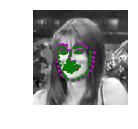

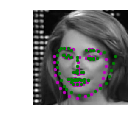

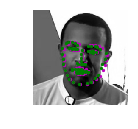

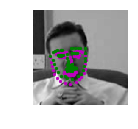

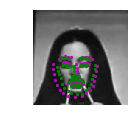

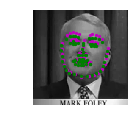

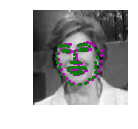

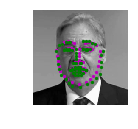

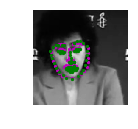

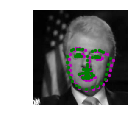

In [116]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [117]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_6.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I tried 6 cases like table below. 


| case    | num of conv | dropout | optimize    | loss | epoch | Loss |
| ------- | ----------- |-------- |------------ |----- |------ |----- |
| case1   | 4           | 0.4     | MSELoss     |Adam  | 10    | 0.050|
| case2   | 4           | 0.4     | SmoothL1Loss|Adam  | 10    | 0.025|
| case3   | 4           | 0.4     | MSELoss     |SGD   | 10    | 0.045|
| case4   | 4           | 0.4     | SmoothL1Loss|SGD   | 10    | 0.025|
| case5   | 4           | 0.2     | SmoothL1Loss|Adam  | 20    | 0.015|
| case6   | 4           | 0.2     | MSELoss     |Adam  | 20    | 0.025|

In the case5, I used SmoothL1Loss and Adam. In this case, I used 0.2 dropout and it starts with bigger loss, but after 20 epoch, I've got about the loss of 0.015. I didn't try to change the number of conv layers because it take lots of time.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I put lots of dropout after each of 4 pool-relu-conv layers and 2 fc layers to avoid overfitting. First conv layer was based on 5x5 kernel, and second, third, fourth layers were based on 3x3 kernel. 
```
        # 4 conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        # Prep for linear layer / Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        # linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
```

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I used on batch size, which is 10. I thought that smaller batch size would be better than larger batch size, so I just went with batch size of 10. I tried epoch of 10 and 20. Both looks good, but the best case was with 20 epochs.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.13280508 -0.01270014 -0.00293511  0.00400863 -0.14178756]
 [ 0.04298167 -0.13992888  0.0325041  -0.17458196 -0.23095299]
 [ 0.10193851  0.0776488  -0.07419415 -0.08392505 -0.02335332]
 [-0.20569059 -0.01686165 -0.1058504   0.07086366  0.20206515]
 [-0.19383132 -0.17220154  0.08978501  0.03818522  0.28241825]]
(5, 5)


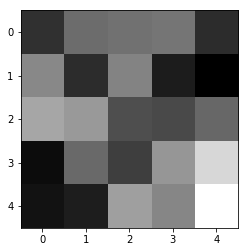

In [122]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_5.pt'
net.load_state_dict(torch.load(model_dir+model_name))

# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
#weights1 = net.conv1.weight.data
weights1 = net.conv1.weight.cpu().data

w = weights1.numpy()

filter_idx = 0

print(w[filter_idx][0])
print(w[filter_idx][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

(5, 5)
(3, 3)


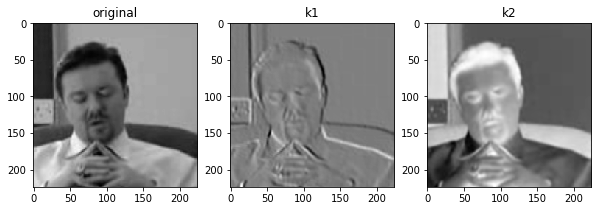

In [161]:
##TODO: load in and display any image from the transformed test dataset
import cv2
test_images=test_images.cpu()

image = test_images[3].data   # get the image from it's wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image=image.reshape((224,224))
k1 = net.conv1.weight.cpu().data.numpy()
k2 = net.conv2.weight.cpu().data.numpy()

filter_idx = 2
print(k1[filter_idx][0].shape)
print(k2[filter_idx][0].shape)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

img1=cv2.filter2D(image,-1,k1[filter_idx][0])
img2=cv2.filter2D(image,-1,k2[filter_idx][0])

f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,4))
ax1.set_title("original")
ax1.imshow(image, cmap='gray')
ax2.set_title("k1")
ax2.imshow(img1, cmap='gray')
ax3.set_title("k2")
ax3.imshow(img2, cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: k1 detects vertical and horizontal edges. k2 detects darker color areas.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!